In [73]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd

np.random.seed(42)


### No confounders

In [74]:
n = 500

# randomly draw treatment
t = np.random.binomial(1, 0.5, size=n)

# treatment effect
tau = 4

# outcome
y = tau * t + np.random.normal(size=n)

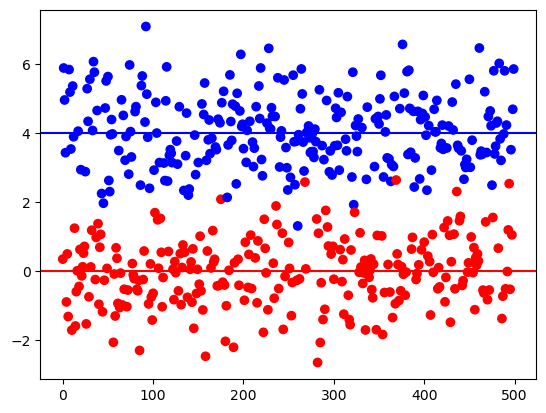

In [75]:
plt.scatter(range(n), y, c=['red' if i == 0 else 'blue' for i in t], marker='o')
plt.axhline(y = 0, color = 'red')
plt.axhline(y = tau, color = 'blue')

In [76]:
np.mean(y[t==1]) - np.mean(y[t==0])

4.102895888143023

In [77]:
T = sm.add_constant(t)
model = sm.OLS(y, T).fit()
model.params

array([-0.04568022,  4.10289589])

### Observed confounder

In [78]:
n = 500
x = np.random.uniform(-3, 3, n)
t = 1 * (x < 0) # if x < 0, you get the treatment, otherwise you get control

In [79]:
tau = 4
y = x + tau * t + np.random.normal(size=n)

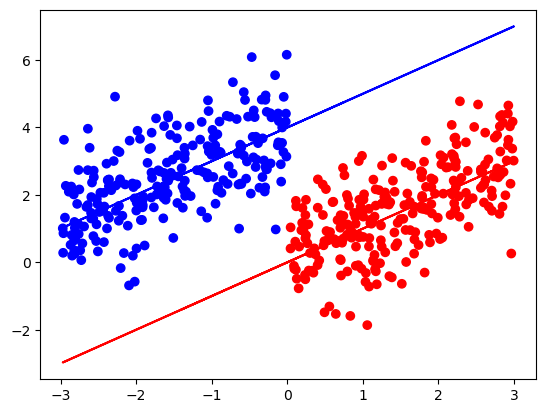

In [80]:
plt.scatter(x, y, c=['red' if i == 0 else 'blue' for i in t], marker='o')
plt.plot(x, x, color = 'red')
plt.plot(x, x + tau, color = 'blue')

In [81]:
# no adjustment for x
np.mean(y[t==1]) - np.mean(y[t==0])

0.9664684504837864

In [82]:
df = pd.DataFrame({'t': t, 'x': x})
model = sm.OLS(y, df).fit()
model.params

t    4.092041
x    1.010325
dtype: float64

In [83]:
x = x.reshape(n, 1)
H = x @ np.linalg.inv(x.T @ x) @ x.T
# H = X(t(X)X)^{-1}t(X)

In [84]:
y_adj = (np.eye(n) - H) @ y # residuals after regression on x
t_adj = (np.eye(n) - H) @ t # residuals after regression on x

In [85]:
model = sm.OLS(y_adj, t_adj).fit()
model.params

array([4.09204107])

### Propensity score

In [86]:
# Propensity score
x = np.random.uniform(-3, 3, n)

t_prob = 1/(1 + np.exp(-x)) # exp(x)/(1+exp(x)) -- this is the link function from logistic regression
t = np.random.binomial(1, t_prob, n)

tau = 4
y = x + tau * t + np.random.normal(size=n)

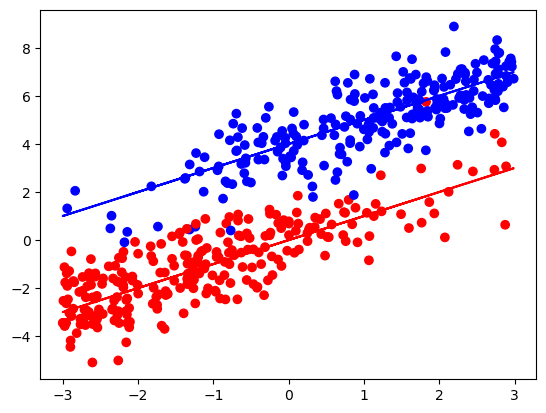

In [87]:
# Plotting
plt.scatter(x, y, c=['red' if i == 0 else 'blue' for i in t], marker='o')
plt.plot(x, x, color='red')
plt.plot(x, x + tau, color='blue')

In [88]:
# Propensity score model - logistic regression predicting T from X (no Y)
X_prop = sm.add_constant(x)
prop_model = sm.GLM(t, X_prop, family=sm.families.Binomial()).fit()

In [89]:
prop_score = prop_model.predict(X_prop)

In [90]:
# Inverse probability weighting (IPW)
ipw = y * t / prop_score - (1 - t) * y / (1 - prop_score)

# if t = 1, y/prop_score, if t = 0, y/(1-prop_score)

print("Mean of IPW:", np.mean(ipw))

Mean of IPW: 3.509055837554188


### Colliders - don't condition on downstream variables

In [91]:
n = 500

# randomly draw treatment
t = np.random.binomial(1, 0.5, size=n)

# treatment effect
tau = 4

# outcome
y = tau * t + np.random.normal(size=n)

x = t + 0.5 * y + np.random.normal(scale = 0.2, size = n)

In [92]:
np.mean(y[t==1]) - np.mean(y[t==0])

3.811283275231993

In [93]:
df = pd.DataFrame({'t': t, 'x': x})
model = sm.OLS(y, df).fit()
model.params

t   -1.039240
x    1.686316
dtype: float64

### Another example of a collider

In [94]:
n = 500

# randomly draw treatment
t = np.random.binomial(1, 0.5, size=n)

# treatment effect
tau = 0

# outcome
y = tau * t + np.random.normal(size=n)

x = t + 0.5 * y + np.random.normal(scale = 0.2, size = n)

In [95]:
np.mean(y[t==1]) - np.mean(y[t==0])

0.020720726541855094

In [96]:
df = pd.DataFrame({'t': t, 'x': x})
model = sm.OLS(y, df).fit()
model.params

t   -1.707209
x    1.733166
dtype: float64